In [1]:
from models_dif import DIFDensityEstimator,SoftmaxWeight,LocationScaleFlow
from targets import DensityEstimationTarget
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import matplotlib.gridspec as gridspec
torch.manual_seed(0)
from torch import nn

In [3]:
example = "Dimension 1"
num_samples = 50000
target = DensityEstimationTarget(example, num_samples)
target_samples = target.get_samples()
p = target_samples.shape[-1]

In [4]:
epochs = 4000
batch_size = 10000
K = 4
initial_w = SoftmaxWeight(K,p,[4,4,4])
initial_T = LocationScaleFlow(K,p)
initial_T.m = nn.Parameter(torch.randn([K,p]))
dif = DIFDensityEstimator(target_samples,K)
dif.w = initial_w
dif.T = initial_T
dif.train(epochs, batch_size)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [1:11:48<00:00,  1.08s/it, loss = 2.848273]


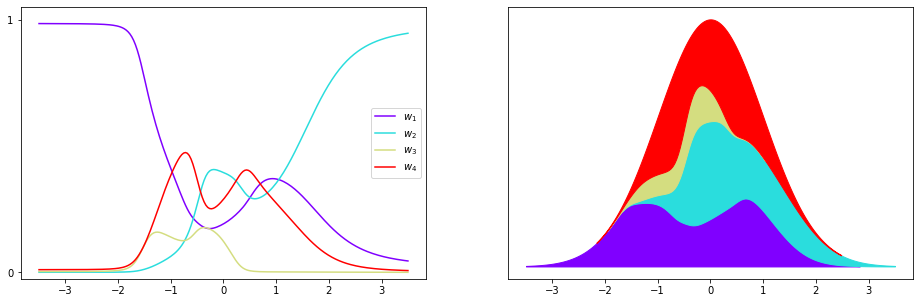

In [5]:
with torch.no_grad():
    color = plt.cm.rainbow(np.linspace(0,1,K))
    tt = torch.linspace(-3.5,3.5,200).unsqueeze(-1).unsqueeze(-2).repeat(1,K,1)
    prob_w = torch.exp(dif.w.log_prob(tt))[:,0,:]
    fig = plt.figure(figsize =(16,5))
    ax1 = plt.subplot(1,2,1)
    ax1.set_yticks(np.arange(0,2,1))
    ax1.set_ylim(bottom = -0.025, top = 1.05)
    tt = tt[:,0,0]
    cum = 0
    for k,c in zip(range(K), color):
        ax1.plot(tt, prob_w[:,k], label = r'$w_'+str(k+1)+'$', color = c)
    ax1.legend()

    ax2 = plt.subplot(1,2,2, sharex = ax1)
    ax2.tick_params(left=False,bottom=True,labelleft=False,labelbottom=True)
    cum = torch.zeros([tt.shape[0]])
    for k, c in zip(range(K), color):
        ancien_cum = cum
        cum = cum + torch.exp(dif.reference.log_density(tt.unsqueeze(-1)))*prob_w[:,k] 
        ax2.fill_between(tt, ancien_cum.numpy(), cum.numpy(), where = torch.abs(ancien_cum - cum)>5e-4, color=c)

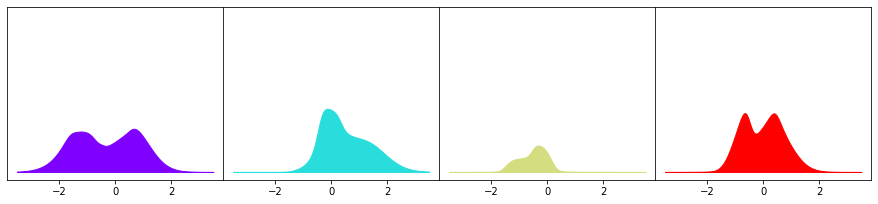

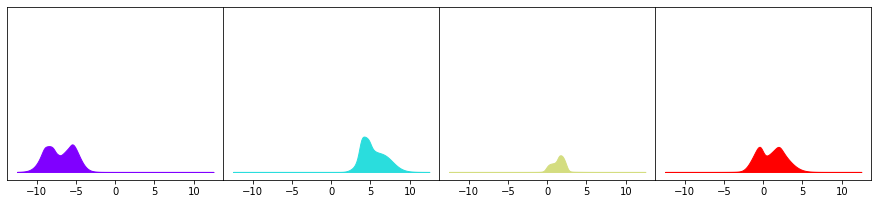

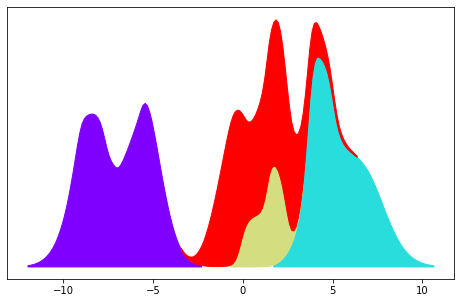

In [6]:
with torch.no_grad():
    tt_z = torch.linspace(-3.5,3.5,200).unsqueeze(-1).unsqueeze(-2).repeat(1,K,1)
    prob_w = torch.exp(dif.w.log_prob(tt_z))[:,0,:]
    fig = plt.figure(figsize = (15,3))
    tt_z = tt_z[:,0,0]
    for k,c in zip(range(K),color):
        ax = fig.add_axes([.8*k/K,.1 , .8/K,.8] ,yticklabels=[], sharey = ax2)
        ax.tick_params(left=False,bottom=True,labelleft=False,labelbottom=True)
        part =torch.exp(dif.reference.log_density(tt_z.unsqueeze(-1)))*prob_w[:,k] 
        ax.fill_between(tt_z, part.numpy(), color = c  )
    fig = plt.figure(figsize = (15,3))
    tt_x = torch.linspace(-12.5,12.5,200).unsqueeze(-1)
    z = dif.T.forward(tt_x)
    prob = torch.diagonal(torch.exp(dif.w.log_prob(z)),0, -2, -1)
    ref = torch.exp(dif.reference.log_density(z))
    det = torch.exp(dif.T.log_det_J(tt))
    total = prob * ref * det
    for k,c in zip(range(K),color):
        ax = fig.add_axes([.8*k/K,.1 , .8/K,.8] ,yticklabels=[], sharey = ax2 )
        ax.tick_params(left=False,bottom=True,labelleft=False,labelbottom=True)
        ax.fill_between(tt_x.squeeze(-1), total[:,k].numpy(), color = c  )  
    plt.plot()
    cum = torch.zeros([tt_x.shape[0]])
    fig = plt.figure(figsize = (8,5))
    plt.tick_params(left=False,bottom=True,labelleft=False,labelbottom=True)
    for k,c in zip(range(K), color):
        ancien_cum = cum
        cum = cum + total[:,k]
        plt.fill_between(tt_x.squeeze(-1), ancien_cum.numpy(), cum.numpy(), where = torch.abs(ancien_cum - cum)>5e-4, color=c)

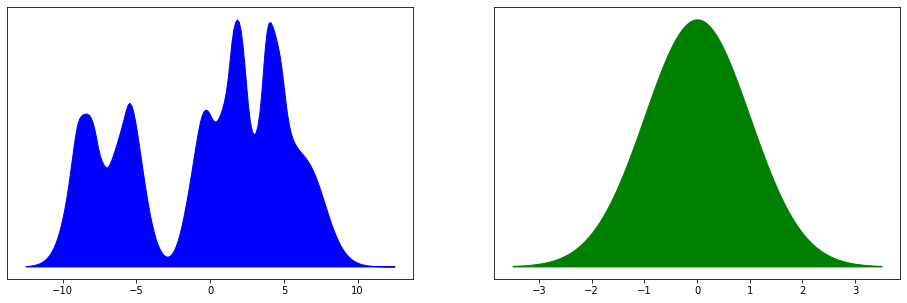

In [8]:
with torch.no_grad():
    density_x = torch.exp(dif.log_density(tt_x))
    density_z = torch.exp(dif.reference.log_density(tt_z.unsqueeze(-1)))
    fig = plt.figure(figsize =(16,5))
    ax1 = plt.subplot(1,2,1)
    ax1.fill_between(tt_x.squeeze(-1).numpy(), density_x.numpy(), color = 'blue')
    ax1.tick_params(left=False,bottom=True,labelleft=False,labelbottom=True)
    ax2 = plt.subplot(1,2,2)
    ax2.tick_params(left=False,bottom=True,labelleft=False,labelbottom=True)
    ax2.fill_between(tt_z.squeeze(-1).numpy(), density_z.numpy(), color = 'green')